# PLRデータ分析例

PLRに保存したデータの取得例です。

本環境は [Jupyter Notebook](https://jupyter.org/) の形で構成されており、[Pythonスクリプト](https://www.python.jp/)を用いて記述しています。

ライブラリは公式イメージ [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) のものがインストールされています。

# チャンネルの取得

処理したいデータが格納されたチャンネルを取得します。cogtask.meにより格納されたデータを処理したい場合は、 `cog-pds-log` となります。


> Jupyter Notebook Serverの起動直後など、実行がなかなか終わらない状態になる可能性があります。
> 実行状態が `[*]` のまま先に進まない場合は 中断(■) を押して一旦中断し、再度実行してみてください。

In [1]:
import asyncio
from plrfs.rpc_client import PLRFSClient

# クライアントライブラリを初期化
loop = asyncio.get_event_loop()

client = await PLRFSClient(loop).connect()

# チャンネル一覧を取得
channels = await client.get_files([])
for ch in channels:
    print('Channel', repr(ch['name']))

Channel 'family'
Channel 'coworkers'
Channel 'friends'
Channel '共有テスト'
Channel 'Garmin Connect活動記録'
Channel 'Cloze Test学習記録'
Channel 'cog-pds-log'
Channel 'cog-pds-log(from googleDrive:yazawa-satoshi@g.ecc.u-tokyo.ac.jp)'


参照したいチャンネル名を以下に記述します。

In [2]:
channel_name = 'cog-pds-log'
channel_name

'cog-pds-log'

In [3]:
channels = await client.get_files([])
cogtask_me_chs = [c for c in channels if c['name'] == channel_name]
assert len(cogtask_me_chs) > 0, 'cogtask.meのチャンネルが見つかりません。'
cogtask_me_ch = cogtask_me_chs[0]
cogtask_me_ch

{'kind': 'folder', 'id': '20210406135701_CwTF', 'name': 'cog-pds-log'}

データの読み込みは `PLRFSClient`から実施できます。これは以下のような関数を持っています。

In [4]:
help(client)

Help on PLRFSClient in module plrfs.rpc_client object:

class PLRFSClient(builtins.object)
 |  PLRFSClient(loop)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, loop)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  async connect(self)
 |  
 |  async get_file(self, path)
 |  
 |  async get_files(self, path)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



ファイルシステムを模した構造になっていて、 `client.get_files` で指定したチャンネル、アイテムの配下のアイテム一覧を取得することができます。また、`client.get_file` で指定したチャンネル、アイテムの配下のデータを取得することができます。


# Garmin Healthデータの取得

試しに、チャンネルからGarmin Healthデータを取り出してみましょう。

In [5]:
task_id = 'GARMIN-V1'
task_id

'GARMIN-V1'

まず、分析対象としたいタスクのIDに合致するログデータを抽出してみます。

In [6]:
import json
import pandas as pd

timeline_item_data = []
# チャンネル内のアイテムを取得する
timeline_items = await client.get_files([cogtask_me_ch['id']])

for item in timeline_items:
    print('Processing...', item['id'])
    # アイテムのプロパティを取得する
    timeline_properties = await client.get_files([cogtask_me_ch['id'], item['id']])
    if 'cogPDSJSON' not in [p['name'] for p in timeline_properties]:
        continue
    
    # プロパティごとのデータを取得する
    cogPDSJSON = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSJSON'][0]])
    cogPDSJSONDict = json.loads(cogPDSJSON['content'])
    if 'meta' in cogPDSJSONDict and 'task' in cogPDSJSONDict['meta'] and cogPDSJSONDict['meta']['task']['id'] == task_id:
        assert 'cnt' in [p['name'] for p in timeline_properties]
        assert 'begin' in [p['name'] for p in timeline_properties]
        summary = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cnt'][0]])
        begin = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'begin'][0]])
        if 'cogPDSUser' in [p['name'] for p in timeline_properties]:
            cogPDSUser = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSUser'][0]])
        else:
            cogPDSUser = None
        timeline_item_data.append((summary['content'].decode('utf8'), begin['content'].decode('utf8'),
                                   cogPDSUser['content'].decode('utf8') if cogPDSUser is not None else None, json.loads(cogPDSJSON['content'])))

df = pd.DataFrame(timeline_item_data, columns=['Summary', 'Time', 'User', 'Detail'])
df

Processing... #20210406224204_dTJy
Processing... #20210406224206_QA95
Processing... #20210406230009_fhsd
Processing... #20210406230003_EknP
Processing... #20210406225911_WCmC
Processing... #20210406230006_8yVF
Processing... #20210407010607_FEja
Processing... #20210407010804_hdRo
Processing... #20210407011104_UzZ5
Processing... #20210407011404_jbSi
Processing... #20210407012509_e5HS
Processing... #20210407012604_uFFV
Processing... #20210520010909_Cq8d
Processing... #20210520010905_mr9s
Processing... #20210407135905_HQPh
Processing... #20210408032308_Sw7p
Processing... #20210408032304_oUp5
Processing... #20210422020703_RGI1
Processing... #20210429213205_HhVe
Processing... #20210510074103_yDbD
Processing... #20210511023003_wAqO
Processing... #20210513051402_P0ae
Processing... #20210513052009_ED-2
Processing... #20210513052003_3ml7
Processing... #20210513052908_E1k5
Processing... #20210513052903_cU1t
Processing... #20210513134109_d4uT
Processing... #20210513134015_oCiE
Processing... #20210

,Summary,Time,User,Detail
0,Garminデータが同期されました: sleeps,2021-06-08T22:22:02.469Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
1,Garminデータが同期されました: stressDetails,2021-06-08T22:22:02.469Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
2,Garminデータが同期されました: dailies,2021-06-08T22:22:02.469Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
3,Garminデータが同期されました: epochs,2021-06-08T22:22:02.469Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
4,Garminデータが同期されました: stressDetails,2021-06-08T22:37:02.585Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
...,...,...,...,...
168,Garminデータが同期されました: epochs,2021-06-29T21:37:04.724Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
169,Garminデータが同期されました: sleeps,2021-06-29T21:37:04.724Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
170,Garminデータが同期されました: sleeps,2021-06-29T21:37:04.724Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."
171,Garminデータが同期されました: stressDetails,2021-06-29T21:37:04.724Z,None,"{'meta': {'task': {'id': 'GARMIN-V1', 'title':..."


このようにして、Personary上のデータをメモリに読み込むことができます。これらの内容を**暗号化等をかけていないファイル等に出力する際は十分に取り扱いに注意**してください。

各データの `Detail` にはログが記録されています。

In [7]:
# .values[-1]でlist最後のデータを参照
df['Detail'].values[-1]

{'meta': {'task': {'id': 'GARMIN-V1', 'title': 'Garmin Connect V1'},
  'garmin': {'dataType': 'dailies',
   'pulled': 1625002624724,
   'ping': 'j7DdLERIvI5V4ttMZ0TJ'}},
 'data': [{'summaryId': 'x2cbe65b-60db3570-5c94-6',
   'calendarDate': '2021-06-30',
   'activityType': 'WALKING',
   'activeKilocalories': 0,
   'bmrKilocalories': 583,
   'steps': 35,
   'distanceInMeters': 27,
   'durationInSeconds': 23700,
   'activeTimeInSeconds': 120,
   'startTimeInSeconds': 1624978800,
   'startTimeOffsetInSeconds': 32400,
   'moderateIntensityDurationInSeconds': 0,
   'vigorousIntensityDurationInSeconds': 0,
   'floorsClimbed': 0,
   'minHeartRateInBeatsPerMinute': 53,
   'maxHeartRateInBeatsPerMinute': 71,
   'averageHeartRateInBeatsPerMinute': 59,
   'restingHeartRateInBeatsPerMinute': 59,
   'timeOffsetHeartRateSamples': {'15': 70,
    '30': 70,
    '45': 70,
    '60': 70,
    '75': 70,
    '90': 70,
    '105': 70,
    '120': 70,
    '135': 70,
    '150': 70,
    '165': 70,
    '180': 70,
 

# 分析例1: 睡眠時間

睡眠時間の変化を分析してみます。

睡眠時間のデータには、 `{'meta': {'garmin': { 'dataType': 'sleeps' }}}` というデータが格納されていますので、これを目印にします。

また、Detailsのdataには以下の項目を持つdictionaryのlistが格納されます。

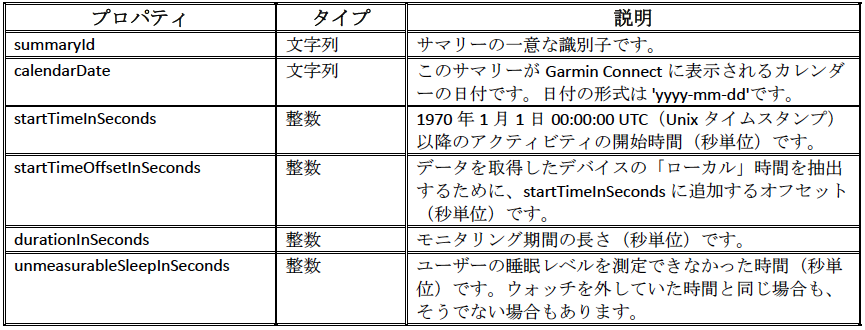


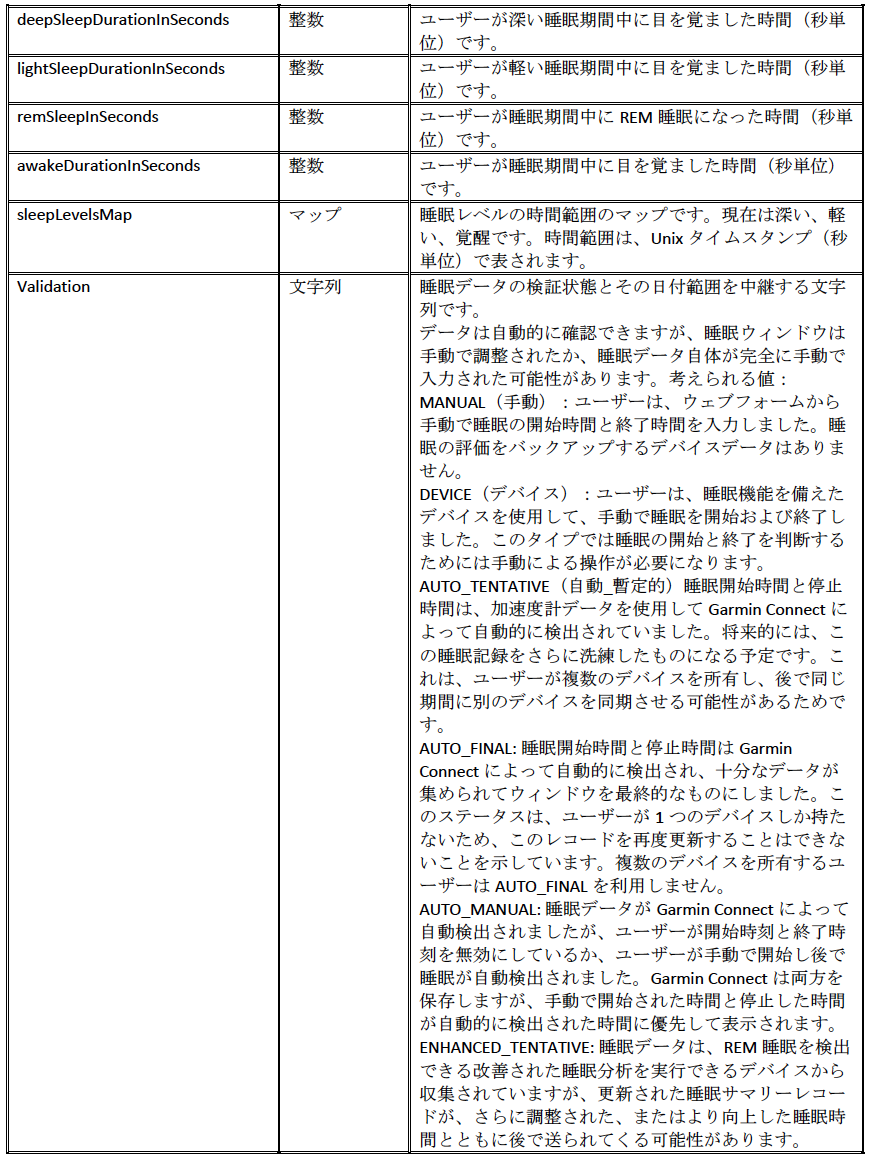

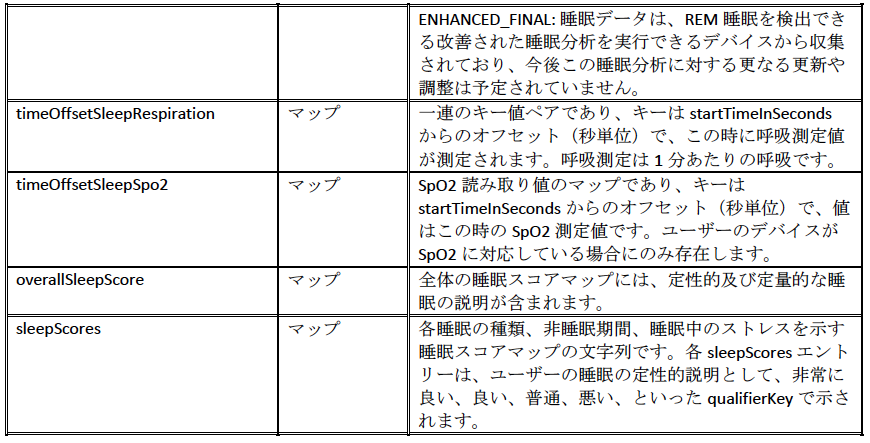

In [10]:
from datetime import datetime, timezone

# 睡眠記録をまとめたPandas DataFrameを返す
def log_to_sleeps(log):
    if log['meta']['garmin']['dataType'] != 'sleeps':
        return None
    sleeps = []
    for sleep in log['data']:
        sleeps.append((
            # おまじない: utcfromtimestampは1970/1/1からの経過時間を秒で扱う
            datetime.fromtimestamp(sleep['startTimeInSeconds'], tz=timezone.utc),
            sleep['unmeasurableSleepInSeconds'],
            sleep['deepSleepDurationInSeconds'],
            sleep['lightSleepDurationInSeconds'],
            sleep['remSleepInSeconds'],
            sleep['awakeDurationInSeconds'],
        ))
    return pd.DataFrame(sleeps, columns=['Start', 'Unmeasurable', 'Deep', 'Light', 'REM', 'Awake'])

log_to_sleeps(df[df['Summary'] == 'Garminデータが同期されました: sleeps']['Detail'].values[-1])

,Start,Unmeasurable,Deep,Light,REM,Awake
0,2021-06-28 15:08:00+00:00,0,3060,15120,5340,0
1,2021-06-29 14:05:00+00:00,0,3000,19620,4200,120


記録されている自分の睡眠記録を全て抽出してみましょう。

In [16]:
sleep_dfs = []
for time, detail in df[df['Summary'] == 'Garminデータが同期されました: sleeps'][['Time', 'Detail']].values:
    sleep_df = log_to_sleeps(detail)
    # データが更新された時刻もDataFrameに記録しておく
    sleep_df['Updated'] = time
    sleep_dfs.append(sleep_df)
sleep_df = pd.concat(sleep_dfs)
sleep_df

,Start,Unmeasurable,Deep,Light,REM,Awake,Updated
0,2021-06-07 15:06:00+00:00,0,2340,15780,3540,0,2021-06-08T22:22:02.469Z
1,2021-06-08 15:22:00+00:00,0,3120,16980,1680,60,2021-06-08T22:22:02.469Z
0,2021-06-07 15:06:00+00:00,0,2340,15780,3540,0,2021-06-09T01:22:01.490Z
1,2021-06-08 15:22:00+00:00,0,3060,17040,1680,60,2021-06-09T01:22:01.490Z
0,2021-06-09 14:11:00+00:00,0,4020,7440,0,0,2021-06-09T21:32:00.852Z
...,...,...,...,...,...,...,...
2,2021-06-28 15:08:00+00:00,0,3060,15120,5340,0,2021-06-28T21:42:04.858Z
0,2021-06-29 15:07:00+00:00,0,2340,7740,0,0,2021-06-29T18:02:03.605Z
0,2021-06-29 15:07:00+00:00,0,2820,20100,0,0,2021-06-29T21:37:04.724Z
0,2021-06-28 15:08:00+00:00,0,3060,15120,5340,0,2021-06-29T21:37:04.724Z


データには再送が含まれている場合があるので、重複を削除する。

In [22]:
# Startに重複がある場合、更新時間が新しいものを採用
sleep_df = sleep_df.sort_values('Updated').drop_duplicates(subset='Start', keep='last').sort_values('Start')
sleep_df

,Start,Unmeasurable,Deep,Light,REM,Awake,Updated
0,2021-06-07 15:06:00+00:00,0,2340,15780,3540,0,2021-06-09T01:22:01.490Z
0,2021-06-08 15:22:00+00:00,0,3060,17040,1680,60,2021-06-10T16:42:02.134Z
0,2021-06-09 14:11:00+00:00,0,4020,7440,0,0,2021-06-09T21:32:00.852Z
1,2021-06-09 15:03:00+00:00,0,1860,15600,5520,60,2021-06-09T21:32:00.852Z
1,2021-06-09 15:04:00+00:00,0,1680,16980,6360,60,2021-06-09T22:07:01.994Z
0,2021-06-09 15:05:00+00:00,0,1620,17160,6180,60,2021-06-16T00:57:00.821Z
0,2021-06-10 14:48:00+00:00,0,2160,22140,0,240,2021-06-10T21:52:02.275Z
0,2021-06-10 14:50:00+00:00,0,2400,17160,5280,60,2021-06-16T01:02:03.153Z
1,2021-06-10 14:51:00+00:00,0,2760,16860,5100,60,2021-06-10T21:52:02.275Z
1,2021-06-11 14:50:00+00:00,0,1920,19020,2640,420,2021-06-16T01:02:03.153Z


# 分析例2: 脈拍数

脈拍数の変化を分析してみます。

脈拍数のデータは、 `{'meta': {'garmin': { 'dataType': 'dailies' }}}` というデータに格納されていますので、これを目印にします。

また、睡眠時間と同様に、Detailsのdataには以下の項目を持つdictionaryのlistが格納されます。

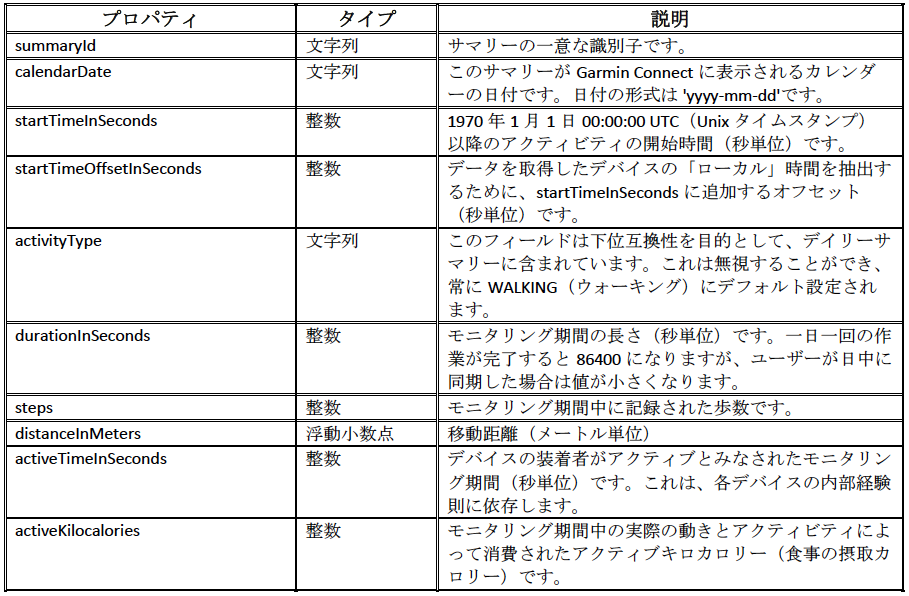

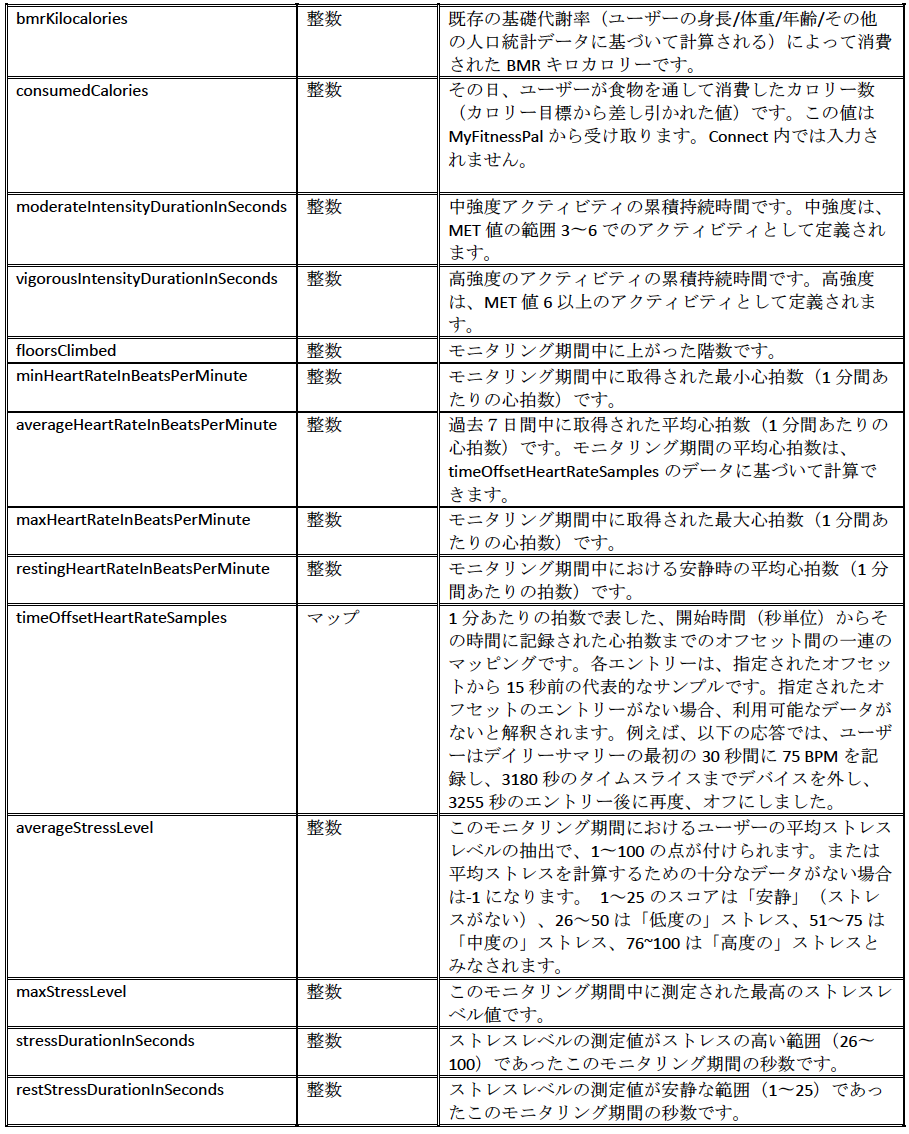

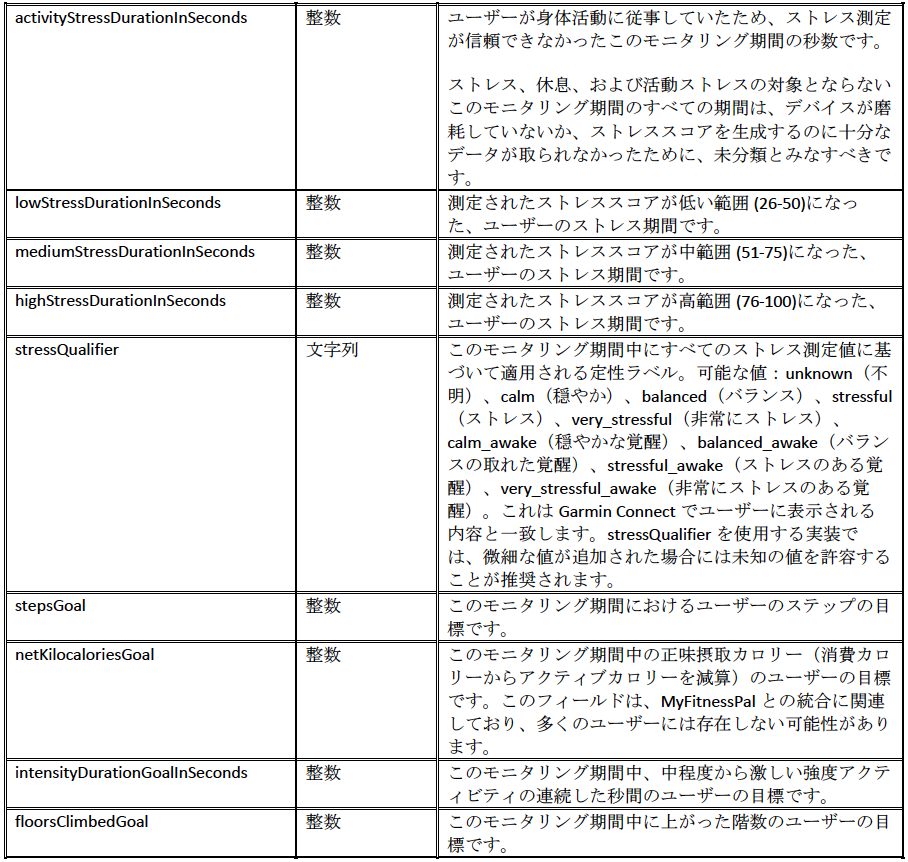

In [29]:
from datetime import datetime, timezone

# 脈拍数変化をまとめたPandas DataFrameを返す
def log_to_heartrates(log):
    if log['meta']['garmin']['dataType'] != 'dailies':
        return None
    heartrates = []
    for daily in log['data']:
        for offset, bpm in daily['timeOffsetHeartRateSamples'].items():
            heartrates.append((
                # おまじない: utcfromtimestampは1970/1/1からの経過時間を秒で扱う
                datetime.fromtimestamp(daily['startTimeInSeconds'] + int(offset), tz=timezone.utc),
                bpm,
            ))
    return pd.DataFrame(heartrates, columns=['Time', 'BPM'])

log_to_heartrates(df[df['Summary'] == 'Garminデータが同期されました: dailies']['Detail'].values[-1])

,Time,BPM
0,2021-06-29 15:00:15+00:00,70
1,2021-06-29 15:00:30+00:00,70
2,2021-06-29 15:00:45+00:00,70
3,2021-06-29 15:01:00+00:00,70
4,2021-06-29 15:01:15+00:00,70
...,...,...
1575,2021-06-29 21:34:00+00:00,59
1576,2021-06-29 21:34:15+00:00,69
1577,2021-06-29 21:34:30+00:00,69
1578,2021-06-29 21:34:45+00:00,69


記録されている自分の脈波記録を全て抽出してみましょう。

In [30]:
heartrate_dfs = []
for time, detail in df[df['Summary'] == 'Garminデータが同期されました: dailies'][['Time', 'Detail']].values:
    heartrate_df = log_to_heartrates(detail)
    # データが更新された時刻もDataFrameに記録しておく
    heartrate_df['Updated'] = time
    heartrate_dfs.append(heartrate_df)
heartrate_df = pd.concat(heartrate_dfs)
heartrate_df

,Time,BPM,Updated
0,2021-06-08 15:00:15+00:00,70,2021-06-08T22:22:02.469Z
1,2021-06-08 15:00:30+00:00,70,2021-06-08T22:22:02.469Z
2,2021-06-08 15:00:45+00:00,70,2021-06-08T22:22:02.469Z
3,2021-06-08 15:01:00+00:00,70,2021-06-08T22:22:02.469Z
4,2021-06-08 15:01:15+00:00,70,2021-06-08T22:22:02.469Z
...,...,...,...
1575,2021-06-29 21:34:00+00:00,59,2021-06-29T21:37:04.724Z
1576,2021-06-29 21:34:15+00:00,69,2021-06-29T21:37:04.724Z
1577,2021-06-29 21:34:30+00:00,69,2021-06-29T21:37:04.724Z
1578,2021-06-29 21:34:45+00:00,69,2021-06-29T21:37:04.724Z


データには再送分があるので、重複を削除する。

In [31]:
# Timeに重複がある場合、更新時間が新しいものを採用
heartrate_df = heartrate_df.sort_values('Updated').drop_duplicates(subset='Time', keep='last').sort_values('Time')
heartrate_df

,Time,BPM,Updated
0,2021-06-08 15:00:15+00:00,70,2021-06-09T21:32:00.852Z
1,2021-06-08 15:00:30+00:00,70,2021-06-09T21:32:00.852Z
2,2021-06-08 15:00:45+00:00,70,2021-06-09T21:32:00.852Z
3,2021-06-08 15:01:00+00:00,70,2021-06-09T21:32:00.852Z
4,2021-06-08 15:01:15+00:00,70,2021-06-09T21:32:00.852Z
...,...,...,...
1575,2021-06-29 21:34:00+00:00,59,2021-06-29T21:37:04.724Z
1576,2021-06-29 21:34:15+00:00,69,2021-06-29T21:37:04.724Z
1577,2021-06-29 21:34:30+00:00,69,2021-06-29T21:37:04.724Z
1578,2021-06-29 21:34:45+00:00,69,2021-06-29T21:37:04.724Z


脈拍数の変化をグラフで見てみよう。グラフを使う場合は以下のおまじないを実行します。

In [32]:
%matplotlib inline

pandas DataFrameの `.plot` でグラフを描くことができます。

<AxesSubplot:xlabel='Time'>

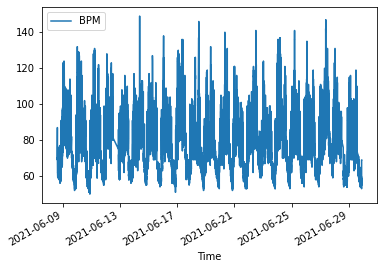

In [33]:
heartrate_df.set_index('Time')[['BPM']].plot()

日時の範囲を絞るには以下のようにする...

<AxesSubplot:xlabel='Time'>

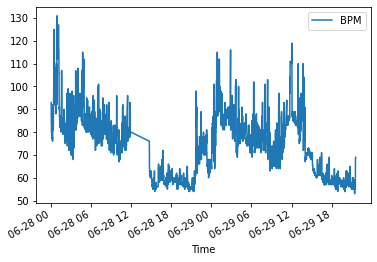

In [34]:
heartrate_df.set_index('Time')['2021-06-28':][['BPM']].plot()

ここで時刻は UTC (日本時間 - 9時間)であることに注意してください。Garminを外している際などはデータが欠落していることがわかります。